In [1]:
# !kaggle datasets download uom190346a/sleep-health-and-lifestyle-dataset

In [2]:
# !unzip sleep-health-and-lifestyle-dataset.zip

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import shap

In [5]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', index_col='Person ID')
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [6]:
df['Blood Pressure'].unique()

array(['126/83', '125/80', '140/90', '120/80', '132/87', '130/86',
       '117/76', '118/76', '128/85', '131/86', '128/84', '115/75',
       '135/88', '129/84', '130/85', '115/78', '119/77', '121/79',
       '125/82', '135/90', '122/80', '142/92', '140/95', '139/91',
       '118/75'], dtype=object)

Датасет, определяющий, насколько образ жизни человека влияет на его расстройства сна. Среди признаков: пол и профессию мы разобьем дамми-кодированием, индекс массы тела сведем к двум значениям - норма (0) и ожирение (1). У кровяного давления в отдельные столюцы вынесем верхнее и нижнее давление, а в целевом значении объединим апноэ и бессоницу в 1 (наличие расстройства сна), а значение NaN - в 0 (отсутствие расстройства сна).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 1 to 374
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Blood Pressure           374 non-null    object 
 9   Heart Rate               374 non-null    int64  
 10  Daily Steps              374 non-null    int64  
 11  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 38.0+ KB


In [8]:
df['Gender'].value_counts()

Gender
Male      189
Female    185
Name: count, dtype: int64

In [9]:
df = pd.get_dummies(df, columns=['Gender'], dtype=int)

In [10]:
df['Occupation'].value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

In [11]:
df['Occupation'].replace(['Nurse', 'Doctor', 'Engineer', 'Lawyer', 'Teacher', 'Accountant', 
                          'Salesperson', 'Software Engineer', 'Scientist', 
                          'Sales Representative', 'Manager'], 
                         ['Medicine', 'Medicine', 'Engineering', 'Law', 'Science & Education', 
                          'Finance', 'Sales', 'Engineering', 'Science & Education', 'Sales', 
                          'Sales'], inplace=True)

df = pd.get_dummies(df, columns=['Occupation'], dtype=int)

In [12]:
df['BMI Category'].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [13]:
df['BMI Category'].replace(['Normal', 'Normal Weight', 'Overweight', 'Obese'], 
                           [0, 0, 1, 1], inplace=True)

In [14]:
df['Blood Pressure'].unique()

array(['126/83', '125/80', '140/90', '120/80', '132/87', '130/86',
       '117/76', '118/76', '128/85', '131/86', '128/84', '115/75',
       '135/88', '129/84', '130/85', '115/78', '119/77', '121/79',
       '125/82', '135/90', '122/80', '142/92', '140/95', '139/91',
       '118/75'], dtype=object)

In [15]:
# df['Blood Pressure'] = df['Blood Pressure'].apply(lambda x: float(eval(x)))
# df

In [16]:
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
df = df.astype({'Systolic_BP': np.int64, 'Diastolic_BP': np.int64})
df.drop('Blood Pressure', axis=1, inplace=True)

In [17]:
df['Sleep Disorder'].value_counts()

Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

In [18]:
df['Sleep Disorder'].fillna(0, inplace=True)
df['Sleep Disorder'].replace(['Sleep Apnea', 'Insomnia'], 1, inplace=True)

In [19]:
df.columns.values.tolist()

['Age',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'BMI Category',
 'Heart Rate',
 'Daily Steps',
 'Sleep Disorder',
 'Gender_Female',
 'Gender_Male',
 'Occupation_Engineering',
 'Occupation_Finance',
 'Occupation_Law',
 'Occupation_Medicine',
 'Occupation_Sales',
 'Occupation_Science & Education',
 'Systolic_BP',
 'Diastolic_BP']

In [20]:
ordered_columns = ['Gender_Female', 'Gender_Male', 'Age', 'Occupation_Engineering', 
                   'Occupation_Finance', 'Occupation_Law', 'Occupation_Medicine', 
                   'Occupation_Sales', 'Occupation_Science & Education', 'Sleep Duration', 
                   'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 
                   'BMI Category', 
                   # 'Blood Pressure',
                   'Systolic_BP', 'Diastolic_BP', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']
df = pd.DataFrame(df, columns=ordered_columns)

In [21]:
df.head()

,Gender_Female,Gender_Male,Age,Occupation_Engineering,Occupation_Finance,Occupation_Law,Occupation_Medicine,Occupation_Sales,Occupation_Science & Education,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic_BP,Diastolic_BP,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,,,,,,,,
1,0,1,27,1,0,0,0,0,0,6.1,6,42,6,1,126,83,77,4200,0
2,0,1,28,0,0,0,1,0,0,6.2,6,60,8,0,125,80,75,10000,0
3,0,1,28,0,0,0,1,0,0,6.2,6,60,8,0,125,80,75,10000,0
4,0,1,28,0,0,0,0,1,0,5.9,4,30,8,1,140,90,85,3000,1
5,0,1,28,0,0,0,0,1,0,5.9,4,30,8,1,140,90,85,3000,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 1 to 374
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender_Female                   374 non-null    int64  
 1   Gender_Male                     374 non-null    int64  
 2   Age                             374 non-null    int64  
 3   Occupation_Engineering          374 non-null    int64  
 4   Occupation_Finance              374 non-null    int64  
 5   Occupation_Law                  374 non-null    int64  
 6   Occupation_Medicine             374 non-null    int64  
 7   Occupation_Sales                374 non-null    int64  
 8   Occupation_Science & Education  374 non-null    int64  
 9   Sleep Duration                  374 non-null    float64
 10  Quality of Sleep                374 non-null    int64  
 11  Physical Activity Level         374 non-null    int64  
 12  Stress Level                    374 non-n

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df[ordered_columns[:-1]], 
                                                    df['Sleep Disorder'], random_state=42)

In [24]:
training = MinMaxScaler().fit_transform(x_train)

In [25]:
forest = RandomForestClassifier()
forest.fit(training, y_train)
preds = forest.predict(x_test)

In [26]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, 
                               index=ordered_columns[:-1]).sort_values(ascending=False)

In [27]:
forest_importances

BMI Category                      0.274910
Diastolic_BP                      0.167731
Systolic_BP                       0.138150
Sleep Duration                    0.113476
Age                               0.103502
Heart Rate                        0.049472
Stress Level                      0.031428
Quality of Sleep                  0.025599
Physical Activity Level           0.023036
Daily Steps                       0.016733
Occupation_Medicine               0.011044
Occupation_Engineering            0.010376
Occupation_Science & Education    0.009635
Occupation_Sales                  0.009299
Occupation_Law                    0.006725
Gender_Male                       0.005146
Gender_Female                     0.002681
Occupation_Finance                0.001057
dtype: float64

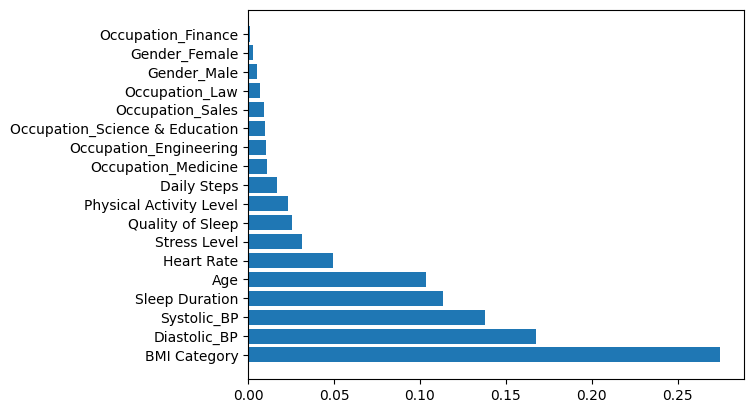

In [28]:
plt.barh(forest_importances.index, forest_importances.values)
plt.show()

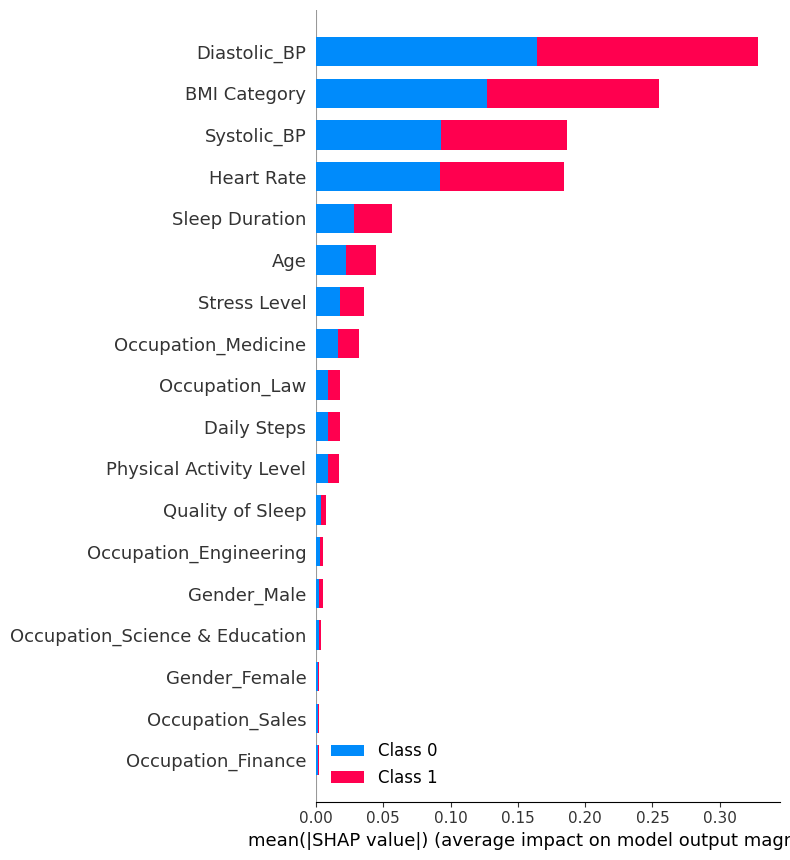

In [29]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(x_test)

shap.initjs()
shap.summary_plot(shap_values, x_test)

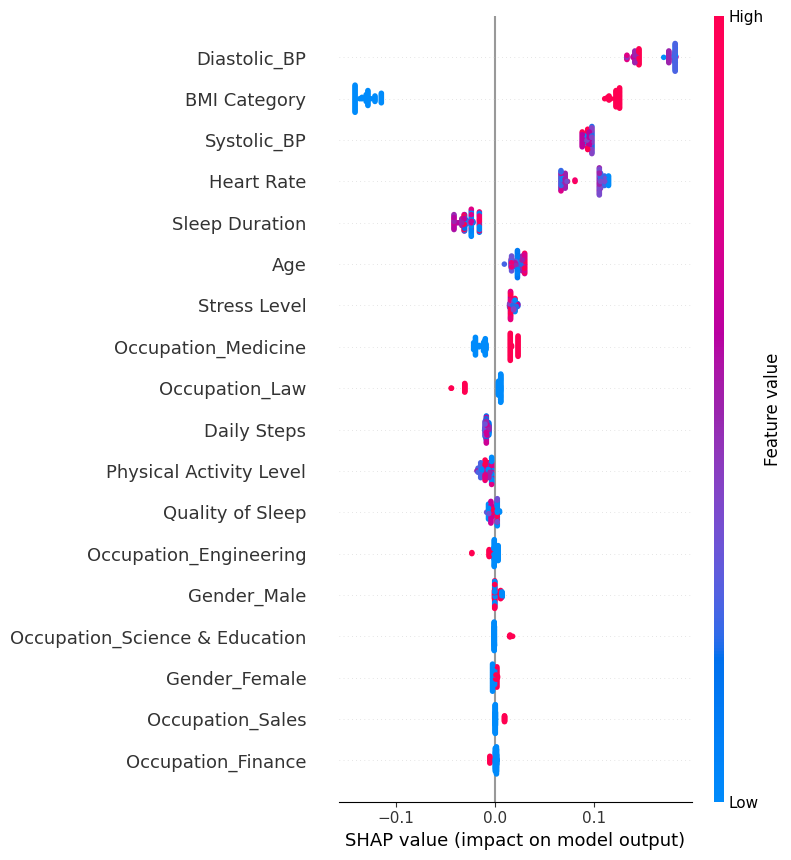

In [30]:
shap.summary_plot(shap_values[1], x_test)

Такой график у нас получился, потому что данные в каждом столбце имеют достаточно ограниченный диапазон значений. Поэтому и график получился "кусочками". В датасете у нас есть один определяющий признак класса: если человек страдает ожирением, то у него будут проблемы со сном. В противном случае - не будет. Модель не учитывает нормальное для человека давление  (потому что просто ничего не знает о нем), и практически любое значение признаков давления, частоты сердцебиения, возраста, уровня стресса всегда находятся в "красной" зоне. Они поднимают возможность попасть в целевой класс. В то же время значения фичей, которые расположились целиком слева от разделительной линии - продолжительность и качество сна, количество шагов в день - всегда оказываются в "синей" зоне. Таким образом, мы можем говорить о позитивных и негативных признаках, которые увеличением своего значения склоняют классификатор к одному или другому классу.

Мы немного поэкспериментировали с признаком давления, сделав его более значимым, но и значимость признака ИМТ тоже возрасла в фича импортансе c 27% до 32%! В сущности, вполне логично, что именно этот признак представляет собой определяющую фичу: он имеет наибольший вес - более 25% от всех признаков. Учитывая, что значения таргета в пределах .3, ИМТ (тоже, к слову, бинарный признак) определяет, к какому классу будет отнесен объект.

In [31]:
r177 = pd.concat([x_test.loc[[177]], y_test[[177]]], axis=1)
r177

,Gender_Female,Gender_Male,Age,Occupation_Engineering,Occupation_Finance,Occupation_Law,Occupation_Medicine,Occupation_Sales,Occupation_Science & Education,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic_BP,Diastolic_BP,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,,,,,,,,
177,0,1,41,0,0,1,0,0,0,7.6,8,90,5,0,130,85,70,8000,0


In [32]:
choosen_instance = x_test.loc[[177]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [33]:
r275 = pd.concat([x_test.loc[[275]], y_test[[275]]], axis=1)
r275

,Gender_Female,Gender_Male,Age,Occupation_Engineering,Occupation_Finance,Occupation_Law,Occupation_Medicine,Occupation_Sales,Occupation_Science & Education,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Systolic_BP,Diastolic_BP,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,,,,,,,,
275,1,0,49,0,0,0,1,0,0,6.2,6,90,8,1,140,95,75,10000,1


In [34]:
choosen_instance = x_test.loc[[275]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)